# imgAna_OpenCV 

In the past a service was invoked to locate faces, this is a replacement for that outboard processing locating
the faces using an OpenCV components. 

## Note : 

Getting this build locally and push up to the cloud you need the following...
```bash
pip install opencv-contrib-python
pip install pandas
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
pip install beautifulsoup4
pip install Pillow
```

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import json
import datetime 

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox, Layout

from bs4 import BeautifulSoup

%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout

from  functools import lru_cache
import requests

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context

import time
from PIL import Image,  ImageDraw  # https://pillow.readthedocs.io/en/4.3.x/
import io
import base64
import sys
if '../scripts' not in sys.path:
    sys.path.insert(0, '../scripts')
import cvsupport

from IPython.core.display import HTML


import logging
logging.getLogger("imgAna_OpenCV")

<Logger imgAna_OpenCV (WARNING)>

In [2]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    """
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

## Process a local file
Using OpenCv so some  processing on a local file.
* do some image manipulation
* find the face 

<class 'numpy.ndarray'>
(240, 362, 3)


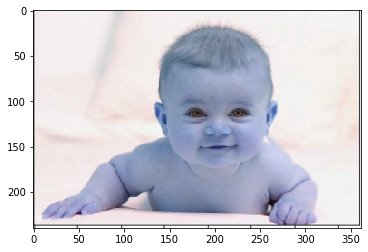

In [3]:
img_raw = cv2.imread('../datasets/baby1.png')
print(type(img_raw))
print(img_raw.shape)
plt.imshow(img_raw)

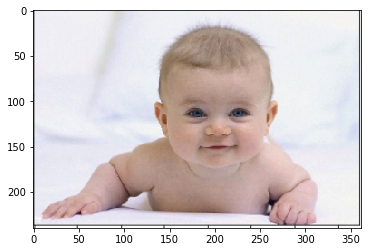

In [4]:
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(convertToRGB(img_raw))

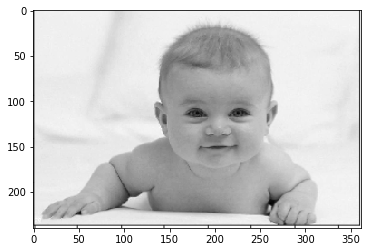

In [5]:
def convertToBW(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(convertToBW(img_raw), cmap='gray')

In [6]:
haar_cascade_face = cv2.CascadeClassifier('../datasets/haarcascade_frontalface_default.xml')
haar_cascade_face

faces_rects = haar_cascade_face.detectMultiScale(convertToBW(img_raw), scaleFactor = 1.2, minNeighbors = 5);

# Let us print the no. of faces found
print("Faces found: {} faces within regions:{}".format(len(faces_rects), faces_rects))


Faces found: 1 faces within regions:[[138  56 140 140]]


## Visualize 
* Find faces
* Draw a box around them

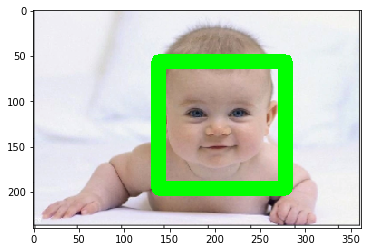

In [7]:
def detect_faces(image, cascade, scaleFactor = 1.1):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = convertToBW(image_copy)

    # Applying the haar classifier to detect faces
    image_rects = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    return image_rects

def rects_render(image, rects):
    image_copy = image.copy()
    for (x, y, w, h) in rects:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 15)
    return image_copy
    
## Render the image with the faces_rects
if len(faces_rects)> 0:
    img_rects = rects_render(convertToRGB(img_raw), faces_rects)
    #print(img_rects)
    plt.imshow(img_rects)
else:
    print("On image")

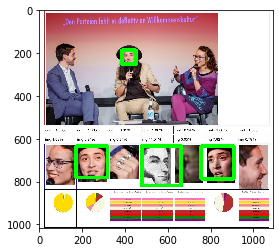

In [8]:
## Another image....
img_raw = cv2.imread('../datasets/imgClassify.jpg')
img_rgb = convertToRGB(img_raw)
rects = detect_faces(img_rgb, haar_cascade_face)
img_rects = rects_render(img_rgb, rects)
plt.imshow(img_rects)

# Fetch a image from the web


Use the the URLs for testing.

In [9]:
# Get and image from the web. 
urls = ["https://media.wired.com/photos/5c5354d391d0df22c1dee493/master/w_2560%2Cc_limit/Backchannel-Lena-Final.jpg",
       "https://upload.wikimedia.org/wikipedia/commons/1/1e/Christopher_de_Paus.JPG",
       "https://upload.wikimedia.org/wikipedia/commons/a/a5/Anne_Bethel_Spencer_in_her_wedding_dress.jpg",
       "https://upload.wikimedia.org/wikipedia/commons/f/f7/Barbara_Anderson_1969.JPG"]
response = requests.get(urls[0])

### OpenCV locate face region : face_rects
- OpenCV to fetch process image, locate the faces.
- OpenCV to render the results.

This processing will be pushed to Streams.


#### face_rects[] is a list of retanges that the face is in

/Users/siegenth/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


Size of image to process :  (1199, 2000, 3)
Found: 2 potential faces. 
 [[1410  432  297  297]
 [ 492  480  282  282]]


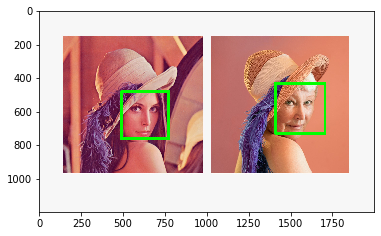

In [10]:
def bts_to_img(bts):
    '''
    :param bts: results from image_to_bts
    '''
    buff = np.fromstring(bts, np.uint8)
    buff = buff.reshape(1, -1)
    img = cv2.imdecode(buff, cv2.IMREAD_COLOR)
    return img

img_raw = bts_to_img(response.content)
print("Size of image to process : ",img_raw.shape)
img_rgb = convertToRGB(img_raw)
face_rects = detect_faces(img_rgb, haar_cascade_face)
print("Found: {} potential faces. \n {}".format(len(face_rects),  face_rects))
img_rects = rects_render(img_rgb, face_rects)
plt.imshow(img_rects)

## Render with face_rects[] - reduce dependency on numpy
Using image from web add the rects. 

- Render in a widget, in a browser. 



In [11]:
def line_box(ele):
    (x,y,w,h)=ele
    return (x,y, x+w,y, x+w,y+h, x,y+w, x,y)
    

def inscribe_rect(bin_image, detection_box):
    """Inscribe box on image
    
    This is updating the image passed in.
    
    Args:
        bin_image : binary image
        detection_box : region to put box around
    Return:
        return image - 
    """
    draw = ImageDraw.Draw(bin_image) 
    box_width = 10 
    draw.line(line_box(detection_box), fill="yellow", width=box_width)
    return bin_image
   

def encode_img(img):
    """must be easier way"""
    with io.BytesIO() as output:
        img.save(output, format="JPEG")
        contents = output.getvalue() 
    return base64.b64encode(contents).decode('ascii')

def decode_img(bin64):
    """must be easier way"""
    img = Image.open(io.BytesIO(base64.b64decode(bin64)))
    return img

def resize_image(bin_image, basewidth=None, baseheight=None):
    """Resize image proportional to the base, make it fit in cell"""
    if basewidth is not None:
        wpercent = (basewidth/float(bin_image.size[0]))
        hsize = int((float(bin_image.size[1])*float(wpercent)))
        return bin_image.resize((basewidth,hsize), Image.ANTIALIAS)
    wpercent = (baseheight/float(bin_image.size[1]))
    wsize = int((float(bin_image.size[0])*float(wpercent)))
    return bin_image.resize((wsize,baseheight), Image.ANTIALIAS)

In [12]:
## Widget to display image
demo_widget = widgets.Output(layout={'border': '1px solid green'})
display(demo_widget)
with Image.open(io.BytesIO(response.content)) as bin_image:
    for rect in face_rects:
        inscribe_rect(bin_image, rect)
    with demo_widget:
        display(bin_image)
        clear_output(wait=True)

Output(layout=Layout(border='1px solid green'))

## Get images from Wiki via Streams

At this point...
- we can fetch images local/web
- render the image in the browser
- locate faces using the OpenCV facility.
- render the image inscribed with 'suspected' face regions. 

Before we push this processing up to Streams we'll process the types of images the Streams applicagtion will be dealing with locally. 
If you have not you need to bring up the the Streams application composed in the [WikiRecentPhase3](./imgAna_3.jupyter-py36.ipynb) notebook. 
This application's view (soupActive) includes the URL of the image being submitted to WikiPedia, the image that we 
are going preform face OpenCV face detection.

We'll do the processing on the Streams, results will be send back. Below were going 
the processing in the browser to work out the processing to do. 

This assumes that you have started the [WikiRecentPhase3](./imgAna_3.jupyter-py36.ipynb) 



<a name="setup"></a>
# Setup
### Add credentials for the IBM Streams service

#### ICPD setup

With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials for the service.

<a target="blank" href="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif">See an example</a>.

In [13]:
# If you using ICP4D insert your creds here...
#from icpd_core import icpd_util
#cfg=icpd_util.get_service_instance_details(name='zen-sample-icp1-blitz-env')

In [14]:
# Accessing Streams Instance & views

def get_instance():
    """Setup to access your Streams instance.

    ..note::The notebook is work within Cloud and ICP4D. 
            Refer to the 'Setup' cells above.              
    Returns:
        instance : Access to Streams instance, used for submitting and rendering views.
    """
    try:
        from icpd_core import icpd_util
        import urllib3
        global cfg
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    except ImportError:
        cfg = None
        print("Outside ICP4D")
        import credential  
        sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', 
                                               vcap_services=credential.vcap_conf)
        instance = sc.get_instances()[0]
    return instance,cfg

instance,cfg = get_instance()

Outside ICP4D


In [15]:
## Fetch the view that has the image URLs.
_view = instance.get_views(name="soupActive")[0]
_view.start_data_fetch()

In [16]:
view_tuples = _view.fetch_tuples(max_tuples=100, timeout=2)

In [17]:
def display_image(view_tuple, image_region=None, rect_region=None, title_region=None, status_region=None, url_region=None):
    img_url = view_tuple['img_desc'][0]['img']
    response = requests.get(img_url)
    
    img_raw = bts_to_img(response.content)
    if img_raw is None:
        print("img_url:{} bts_img() failed".format(img_url))
        return
    img_rgb = convertToRGB(img_raw)
    face_rects = detect_faces(img_rgb, haar_cascade_face)
    status_region.value = "Found: {} potential faces. \n {}".format(len(face_rects),  face_rects)
    # img_rects = rects_render(img_rgb, face_rects)
    url_region.value = img_url
    title_region.value = view_tuple['title']
    with Image.open(io.BytesIO(response.content)) as bin_image:
        with image_region:
            display(resize_image(bin_image, baseheight=300))
            clear_output(wait=True)
            for rect in face_rects:
                inscribe_rect(bin_image, rect)
            with rect_region:
                if len(face_rects) is not 0:
                    display(resize_image(bin_image, baseheight=300))
                    clear_output(wait=True)
                else:
                    clear_output()
         

In [34]:
## Render in 'Dashboard' images that processed locally using OpenCV. Best to get things working 
## locally before pushing it up to Streams. 
## 
## Images are coming from a Wikipedia via a Streams view.
##
status_local = widgets.Label(value="Status", layout={'border': '1px solid green','width':'600%'})
url_local = widgets.Label(value="Img URL", layout={'border': '1px solid green','width':'60%'})
image_local = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'300pt'})
rect_local = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'300pt'})
hbox_local = widgets.HBox([image_local, rect_local])
title_local = widgets.Label(value="Title", layout={'border': '1px solid green','width':'60%'})
dashboard = widgets.VBox([status_local, hbox_local, title_local, url_local])
display(dashboard)

In [35]:
# This cell is going to populate the dashboard above.
## The left pane has the image that arrived, the right 
## show the faces demarked, if none found no image.
## 
## - Re-execute the cell to fetch/process/render images.
## - Note the debug statements below.

@catchInterrupt
def server_soup(count=1):
    """Fetch and display images from view.
    Args::
        count: number of iterations to fetch images, count<0
        is infinite
    """
    while count != 0:
        count -= 1
        view_tuples = _view.fetch_tuples(max_tuples=12, timeout=2)
        print("remaining cycles:{} tuples:{}".format(count, len(view_tuples)))
        for soup_tuple in view_tuples:
            display_image(soup_tuple, image_region=image_local, rect_region=rect_local, title_region=title_local, status_region=status_local, url_region=url_local)

server_soup()

remaining cycles:0 tuples:12


/Users/siegenth/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


## Streams processing


In [20]:
# Streams support - move out....
def list_jobs(_instance=None, cancel=False):
    """
    Interactive selection of jobs to cancel.
    
    Prompts with SelectMultiple widget, if thier are no jobs, your presente with a blank list.
    
    """
    active_jobs = { "{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description = "Cancel jobs(s)" if cancel else "Active job(s):",
        layout=Layout(width='60%')
    )
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job:", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')
    if cancel:
        return HBox([selectMultiple_jobs, cancel_jobs])
    else:
        return HBox([selectMultiple_jobs])

##   To Processing Operators. 
Above we created code to fetch a image from the web and find faces, which is composed a number of functions. 
To push it up to Streams we've rolled up the processing into two functions.

The cvsupport.py in [scripts](../scripts) class that are used below to compose the application.
- ImageFetch[] - web request that puts image in tuple. The most time consuming portion of the processing is fetching the images using the URL. Retrieve the image from and push the image data into the Stream where it will be processed by downstream operator.
- FaceRegions[] - locates faces in image 

### Test the ImageFetch[] & FaceRegions[] before pushing up 

In [21]:
url = "https://media.wired.com/photos/5c5354d391d0df22c1dee493/master/w_2560%2Cc_limit/Backchannel-Lena-Final.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/0/0a/Great_Western_Road%2C_53-100_Kelvin_Court%2C_Glasgow.jpg"
tuple1 = {'img_desc':[{'img':url}]}   # simulate the tuple to process
image_fetch = cvsupport.ImageFetch()

# simulate the Stream.
tuple2 = image_fetch(tuple1)
with cvsupport.FaceRegions(haar_file="../datasets/haarcascade_frontalface_default.xml") as fr:
    print(type(fr))
    tuple3 = fr(tuple2)
#face_region = cvsupport.FaceRegions(haar_file="../datasets/haarcascade_frontalface_default.xml")
#tuple3 = face_region(tuple2)

# render the results.... create a
if tuple3 is not None:
    print(" URL:{}\n had {} regions \n ... {}".format(tuple3['img_desc'][0]['img'], len(tuple3['face_regions']), tuple3['face_regions']))
    verify_widget = widgets.Output(layout={'border': '1px solid green'})
    display(verify_widget)

    response = requests.get(tuple3['img_desc'][0]['img'])  # fetch the image

    with Image.open(io.BytesIO(response.content)) as bin_image:
        for rect in tuple3['face_regions']:
            inscribe_rect(bin_image, rect)
        with verify_widget:
            display(resize_image(bin_image, baseheight=600))
else:
    print("No faces located in image....")

*EXIT invoked type:None value:None


<class 'cvsupport.FaceRegions'>
Size of image to process :  (1199, 2000, 3)
 URL:https://media.wired.com/photos/5c5354d391d0df22c1dee493/master/w_2560%2Cc_limit/Backchannel-Lena-Final.jpg
 had 2 regions 
 ... [[1404, 429, 300, 300], [491, 471, 300, 300]]


Output(layout=Layout(border='1px solid green'))

## Compose and Submit the application.

The Streams application that will get Tuples by subscribing a feed
that is composed in the [WikiRecentPhase3](./imgAna_3.jupyter-py36.ipynb).

In [22]:
## compose the findFaces application
def findFacesApplication():
    """Compose the application
    
       - Subscribe to stream with images urls.
       - fetch the image into 'img_string'
       - finds faces into 'face_regions' 
       - 
       
    """
    topo = Topology("findFaces")
    topo.add_file_dependency('../datasets/haarcascade_frontalface_default.xml', 'etc')
    topo.add_pip_package('opencv-contrib-python')
    
    soup_active = topo.subscribe(topic="soup_active")
    active_image = soup_active.map(cvsupport.ImageFetch(), name="image_fetch")
    active_image.view(name="image_fetch", description="encoded binary image")
    face_regions = active_image.map(cvsupport.FaceRegions(), name="face_regions")
    face_trimmed = face_regions.map(lambda t: {
        'user':t['user'],
        'title':t['title'],
        'url':t['img_desc'][0]['img'], 
        'face_regions':t['face_regions'] 
    }, name="trimmed_view")
    face_trimmed.view(name="trimmed_view", description="drop image")
    return topo


In [23]:
## Submit the findFaces application
topo = findFacesApplication()

if cfg is not None:
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    submission_result = context.submit("DISTRIBUTED",topo, config=cfg)

if cfg is None:
    import credential
    cloud = {
        context.ConfigParams.VCAP_SERVICES: credential.vcap_conf,
        context.ConfigParams.SERVICE_NAME: "Streaming3Turbine",
        context.ContextTypes.STREAMING_ANALYTICS_SERVICE:"STREAMING_ANALYTIC",
        context.ConfigParams.FORCE_REMOTE_BUILD: True,
    }
    submission_result = context.submit("STREAMING_ANALYTICS_SERVICE",topo,config=cloud)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    print("JobId: ", submission_result['id'] , "Name: ", submission_result['name'])


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

JobId:  12 Name:  notebook::findFaces_12


In [28]:
list_jobs(instance, cancel=True)

## View the processing results of the findFaces application 

In [29]:
## Start getting 
_trimmed = instance.get_views(name="trimmed_view")[0]
_trimmed.start_data_fetch()

In [33]:
# render the results.... only images with regions will arrive via this view

title_face = widgets.Label(value="Title", layout={'border': '1px solid green','width':'50%'})
rect_face = widgets.Output(layout={'border': '1px solid red','width':'50%','height':'300pt'})
url_face = widgets.Label(value="URL", layout={'border': '1px solid green','width':'50%'})
dashboard = widgets.VBox([title_face, rect_face, url_face])
display(dashboard)
trimmed = trimmed_tuples[1]

# Fetch the tuples from the view
trimmed_tuples = _trimmed.fetch_tuples(max_tuples=100, timeout=2)

for trimmed in trimmed_tuples:
    response = requests.get(trimmed['url'])  # fetch the image
    title_face.value = trimmed['title']
    url_face.value = trimmed['url']
    with Image.open(io.BytesIO(response.content)) as bin_image:
        for rect in trimmed['face_regions']:
            inscribe_rect(bin_image, rect)
        with rect_face:
            display(resize_image(bin_image, baseheight=600))
            clear_output(wait=True)
